# Reproduce main figures

## 1) Params & setup

In [1]:
# === Params (edit if you used a different output dir) =========================
REPORT_DIR = "../reports/week01_qstrict_cap8"   # folder created by nb.py
FIG_DIR    = "../figures/reproduce"             # where to save reproduced figs
# ============================================================================

import os, sys, math
os.makedirs(FIG_DIR, exist_ok=True)

# Try to import plotting libs; if missing, we'll show pre-rendered PNGs instead.
pd = None
plt = None
try:
    import pandas as pd
    pd = pd
except Exception:
    pass

try:
    import matplotlib
    if "DISPLAY" not in os.environ:
        matplotlib.use("Agg")
    import matplotlib.pyplot as plt
    plt = plt
except Exception:
    pass

from IPython.display import display, Markdown, Image

def need(path): 
    if not os.path.isfile(path):
        raise FileNotFoundError(f"Missing file: {path}")
    return path

PR_CSV   = need(os.path.join(REPORT_DIR, "per_record_stats.csv"))
SUM_CSV  = os.path.join(REPORT_DIR, "by_correctness_summary.csv")       # optional
COV_CSV  = os.path.join(REPORT_DIR, "coverage_by_cell.csv")             # optional
EXCL_CSV = os.path.join(REPORT_DIR, "excluded_by_reason.csv")           # optional

display(Markdown(f"**Using report dir:** `{REPORT_DIR}`  \n**Saving figs to:** `{FIG_DIR}`"))


**Using report dir:** `../reports/week01_qstrict_cap8`  
**Saving figs to:** `../figures/reproduce`

## 2) Quick summary (counts + sanity)

In [3]:
import csv

def load_csv_any(path):
    if pd is not None:
        try:
            return pd.read_csv(path)
        except Exception:
            pass
    with open(path, newline="", encoding="utf-8") as f:
        return list(csv.DictReader(f))

per_record = load_csv_any(PR_CSV)

def as_rows(obj):
    if obj is None: return []
    if pd is not None and hasattr(obj, "to_dict"):
        return obj.to_dict(orient="records")
    return obj

rows = as_rows(per_record)

# normalize correct -> True/False/None
def to_bool(v):
    s = str(v).strip().lower()
    return True if s == "true" else (False if s == "false" else None)

num_total    = len(rows)
num_correct  = sum(1 for r in rows if to_bool(r.get("correct")) is True)
num_incorrect= sum(1 for r in rows if to_bool(r.get("correct")) is False)
num_unknown  = num_total - num_correct - num_incorrect
acc = (num_correct / max(1, (num_correct + num_incorrect))) * 100.0

display(Markdown(
    f"### Summary\n"
    f"- Selected rows: **{num_total}**  \n"
    f"- Correct: **{num_correct}**  \n"
    f"- Incorrect: **{num_incorrect}**  \n"
    f"- Unknown (no GT/pred): **{num_unknown}**  \n"
    f"- Accuracy on labeled: **{acc:.2f}%**"
))

# (Optional) show exclusion reasons if present
if os.path.isfile(EXCL_CSV):
    excl = load_csv_any(EXCL_CSV)

    def has_rows(obj):
        if obj is None:
            return False
        # pandas DataFrame
        if pd is not None and hasattr(obj, "empty"):
            return not obj.empty
        # list-of-dicts fallback
        return isinstance(obj, list) and len(obj) > 0

    if has_rows(excl):
        display(Markdown("**Exclusion reasons:**"))
        if pd is not None and hasattr(excl, "empty"):
            # already a DataFrame
            display(excl)
        else:
            # list-of-dicts -> make a small table
            if pd is not None:
                import pandas as _pd
                display(_pd.DataFrame(excl))
            else:
                for r in excl:
                    print(r)


### Summary
- Selected rows: **7744**  
- Correct: **2804**  
- Incorrect: **4818**  
- Unknown (no GT/pred): **122**  
- Accuracy on labeled: **36.79%**

**Exclusion reasons:**

,reason,count
0,failed_quality_gate,27952
1,hit_cell_cap,4864


## 3) Reproduce main figures 

**01 — Token Length by Correctness**

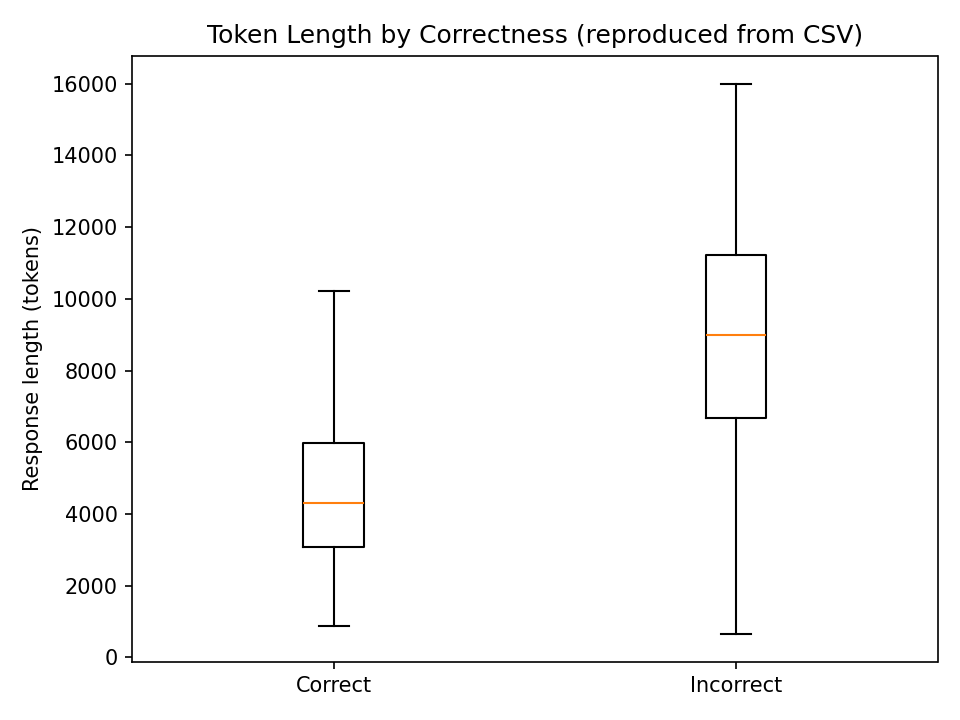

Saved: ../figures/reproduce/01_tok_len_boxplot.png


**02 — Mean −log p (Correct)**

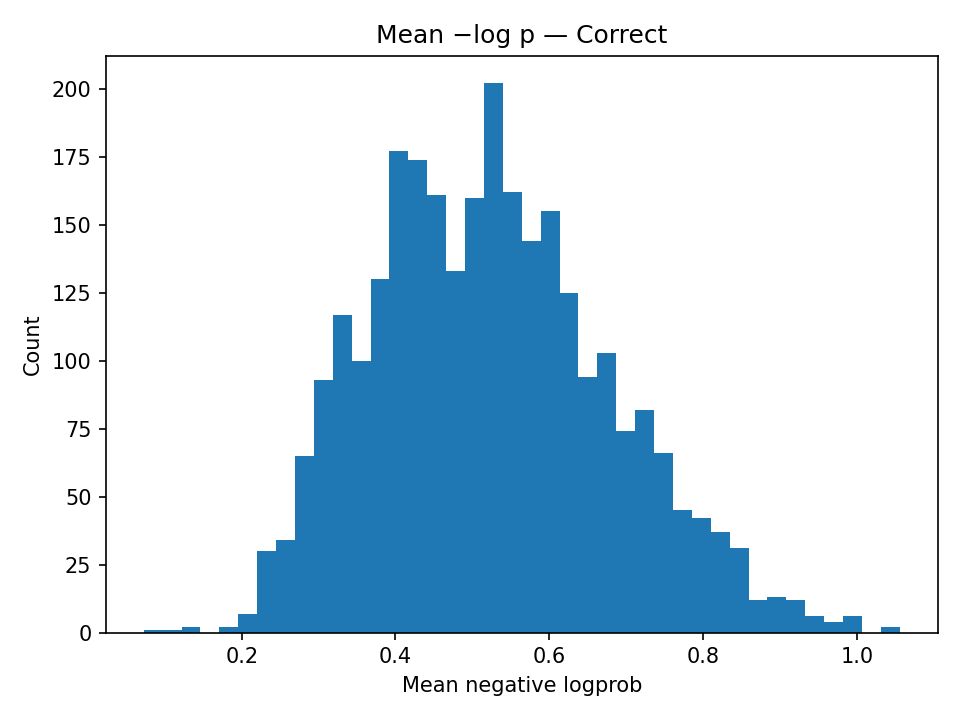

Saved: ../figures/reproduce/02_mean_nlp_hist_correct.png


**03 — Mean −log p (Incorrect)**

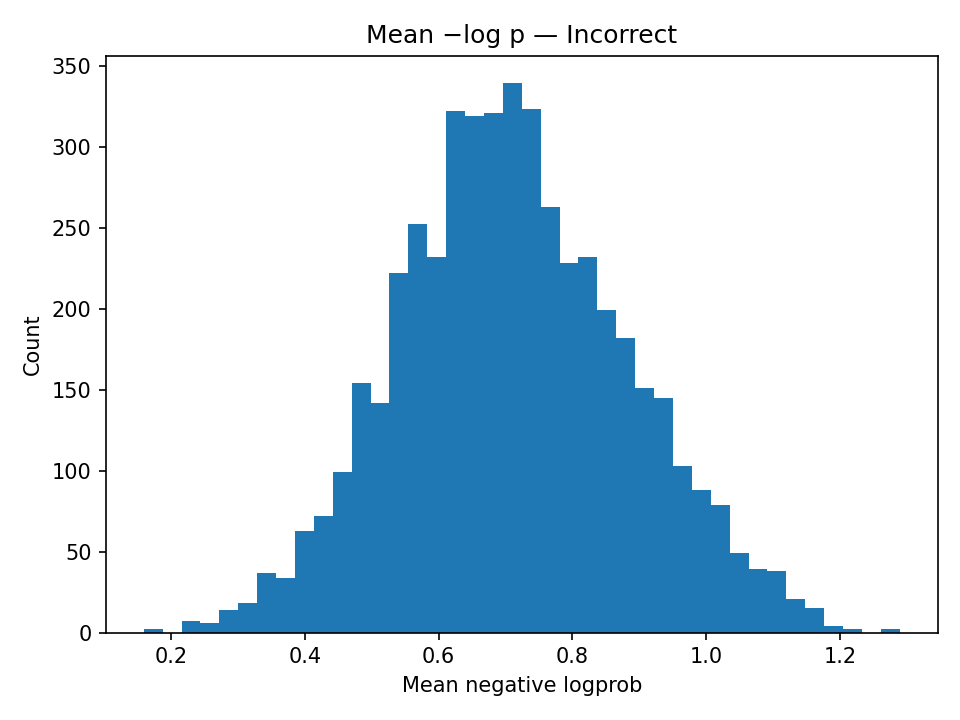

Saved: ../figures/reproduce/03_mean_nlp_hist_incorrect.png


In [4]:
# Reproduce key figures from CSV and DISPLAY them inline.
# If matplotlib isn't available, show the pre-rendered PNGs from REPORT_DIR.

from IPython.display import Image, Markdown

if plt is None:
    display(Markdown("> Matplotlib not available here — showing images rendered during the clean run."))
    for p in ["tok_len_boxplot.png", "mean_nlp_hist_correct.png", "mean_nlp_hist_incorrect.png",
              "resp_len_boxplot.png"]:  # the last one may or may not exist
        img = os.path.join(REPORT_DIR, p)
        if os.path.isfile(img):
            display(Markdown(f"**{p}**"))
            display(Image(filename=img))
else:
    # Prepare dataframe
    if pd is not None and hasattr(per_record, "to_dict"):
        df = per_record.copy()
    else:
        import pandas as _pd, csv as _csv
        with open(PR_CSV, newline="", encoding="utf-8") as f:
            df = _pd.DataFrame(list(_csv.DictReader(f)))

    # Normalize types
    df["correct_bool"] = df["correct"].astype(str).str.lower().map({"true": True, "false": False})
    for col in ("tok_len", "mean_negative_logprob"):
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    def boxplot_with_labels(data, labels):
        try:
            plt.boxplot(data, tick_labels=labels, showfliers=False)  # mpl >= 3.9
        except TypeError:
            plt.boxplot(data, labels=labels, showfliers=False)       # mpl < 3.9

    # --- Fig 1: Token length by correctness ---
    if {"tok_len","correct_bool"}.issubset(df.columns):
        corr = df.loc[df["correct_bool"] == True,  "tok_len"].dropna().tolist()
        inc  = df.loc[df["correct_bool"] == False, "tok_len"].dropna().tolist()
        data, labels = [], []
        if corr: data.append(corr); labels.append("Correct")
        if inc:  data.append(inc);  labels.append("Incorrect")
        if data:
            plt.figure()
            boxplot_with_labels(data, labels)
            plt.ylabel("Response length (tokens)")
            plt.title("Token Length by Correctness (reproduced from CSV)")
            plt.tight_layout()
            out = os.path.join(FIG_DIR, "01_tok_len_boxplot.png")
            plt.savefig(out, dpi=150); plt.close()
            display(Markdown("**01 — Token Length by Correctness**"))
            display(Image(filename=out))
            print("Saved:", out)

    # --- Fig 2a: Mean −log p — Correct ---
    if {"mean_negative_logprob","correct_bool"}.issubset(df.columns):
        d = df.dropna(subset=["mean_negative_logprob", "correct_bool"])
        dc  = d[d["correct_bool"] == True]
        dic = d[d["correct_bool"] == False]

        if not dc.empty:
            plt.figure()
            plt.hist(dc["mean_negative_logprob"].to_list(), bins=40)
            plt.xlabel("Mean negative logprob")
            plt.ylabel("Count")
            plt.title("Mean −log p — Correct")
            plt.tight_layout()
            out = os.path.join(FIG_DIR, "02_mean_nlp_hist_correct.png")
            plt.savefig(out, dpi=150); plt.close()
            display(Markdown("**02 — Mean −log p (Correct)**"))
            display(Image(filename=out))
            print("Saved:", out)

        # --- Fig 2b: Mean −log p — Incorrect ---
        if not dic.empty:
            plt.figure()
            plt.hist(dic["mean_negative_logprob"].to_list(), bins=40)
            plt.xlabel("Mean negative logprob")
            plt.ylabel("Count")
            plt.title("Mean −log p — Incorrect")
            plt.tight_layout()
            out = os.path.join(FIG_DIR, "03_mean_nlp_hist_incorrect.png")
            plt.savefig(out, dpi=150); plt.close()
            display(Markdown("**03 — Mean −log p (Incorrect)**"))
            display(Image(filename=out))
            print("Saved:", out)
